In [1]:
rm -rf pythia_tools

In [2]:
!git clone https://github.com/kmrasmussen/pythia_tools.git pythia_tools
!pip install -e pythia_tools --quiet
!pip install git+https://github.com/neelnanda-io/TransformerLens.git --quiet

Cloning into 'pythia_tools'...
remote: Enumerating objects: 95, done.
remote: Counting objects: 100% (61/61), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 95 (delta 25), reused 47 (delta 14), pack-reused 34
Unpacking objects: 100% (95/95), 57.72 MiB | 9.58 MiB/s, done.
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 85.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 78.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 14.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 40.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 113.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 26.0 MB/

In [3]:
import torch
import sys
sys.path.append("pythia_tools")
from pythia_tools.qh import get_similarity_matrix
from pythia_tools.models import get_model, yield_models, get_n_layers
import matplotlib.pyplot as plt
from tqdm import tqdm
from pythia_tools.visualization import hist_and_box
from pythia_tools.qh import mem_size
from pythia_tools.data import get_token_mat

In [4]:
def get_many_pres(seq_ids, layer):
  pres = []
  for seq_id in tqdm(seq_ids):
    logits, cache = model.run_with_cache(T[seq_id], prepend_bos=False, remove_batch_dim=True, stop_at_layer=layer+1)
    pre = torch.clone(cache[f'blocks.{layer}.mlp.hook_pre'])
    del logits
    del cache
    torch.cuda.empty_cache()
    pres.append(pre)
  return torch.stack(pres)

In [5]:
def get_many_pres_all_layers_decorr(model, seq_ids):
  pres = []
  for seq_id in tqdm(seq_ids):
    logits, cache = model.run_with_cache(T[seq_id], prepend_bos=False, remove_batch_dim=True)
    pre = [torch.clone(cache[f'blocks.{layer}.mlp.hook_pre'][-1]) for layer in range(get_n_layers(model))]
    del logits
    del cache
    torch.cuda.empty_cache()
    pres.append(torch.stack(pre))
  return torch.stack(pres) # seqs, layers, neurons

In [9]:
def get_many_pres_all_layers(model, seq_ids):
  pres = []
  for seq_id in tqdm(seq_ids):
    logits, cache = model.run_with_cache(T[seq_id], prepend_bos=False, remove_batch_dim=True)
    pre = [torch.clone(cache[f'blocks.{layer}.mlp.hook_pre']) for layer in range(get_n_layers(model))]
    del logits
    del cache
    torch.cuda.empty_cache()
    pres.append(torch.stack(pre))
    del pre
  ret = torch.stack(pres)
  del pres
  return ret # seqs, layers, position, neurons

In [10]:
T = get_token_mat()

torch.Size([10691, 600])


Using pad_token, but it is not set yet.


Loaded pretrained model pythia-70m-deduped into HookedTransformer


100%|██████████| 10/10 [00:00<00:00, 14.93it/s]


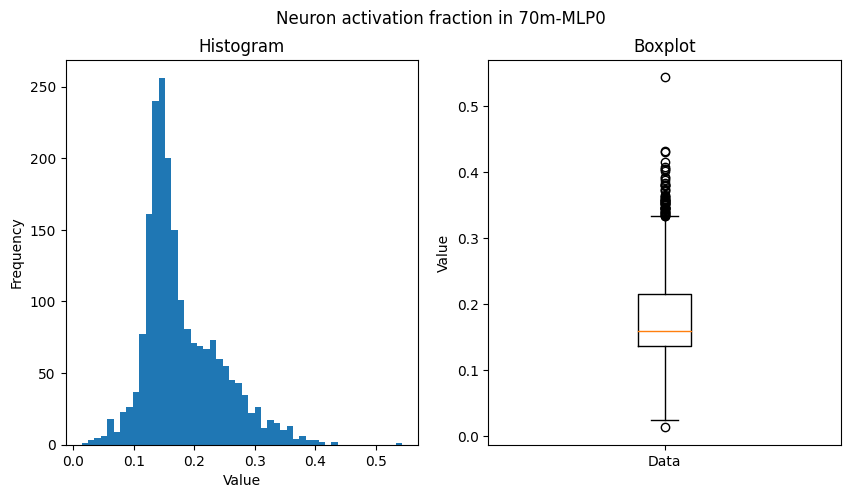

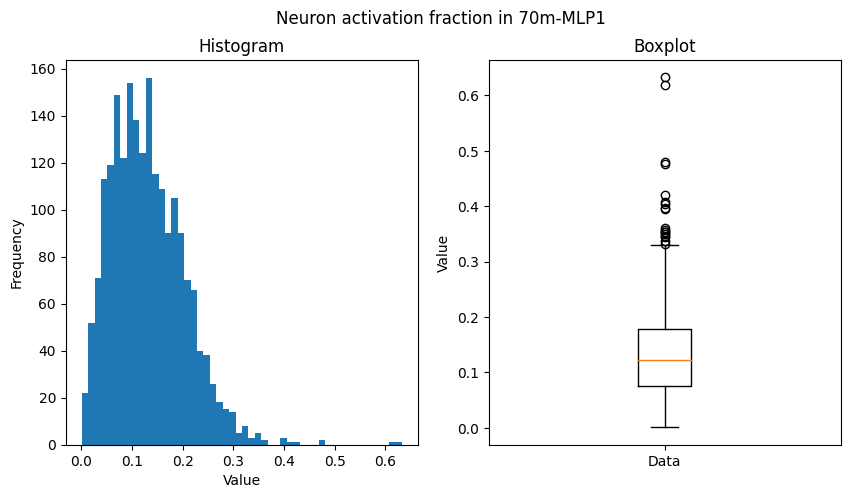

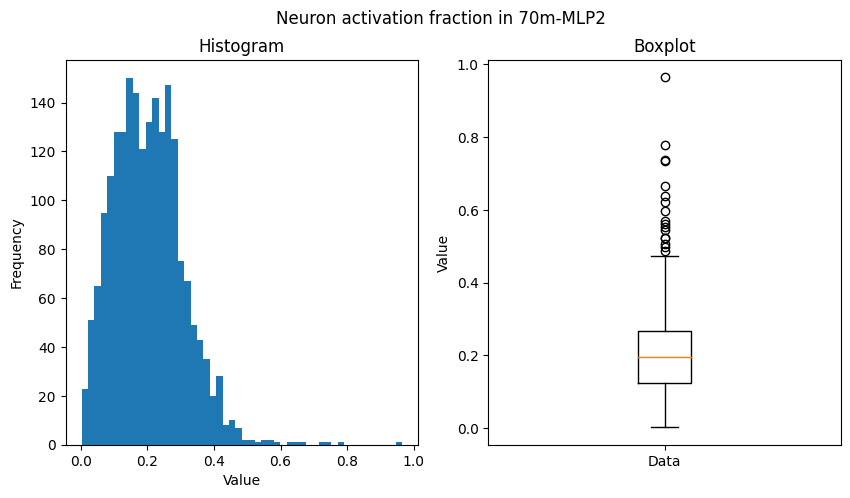

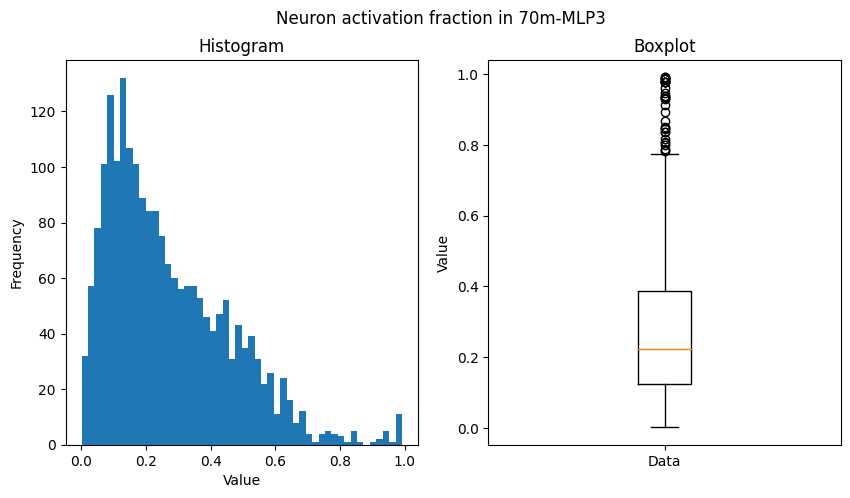

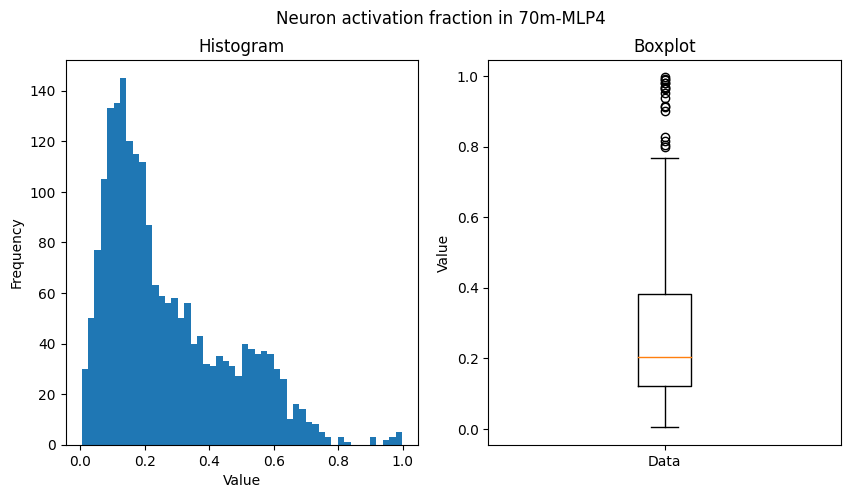

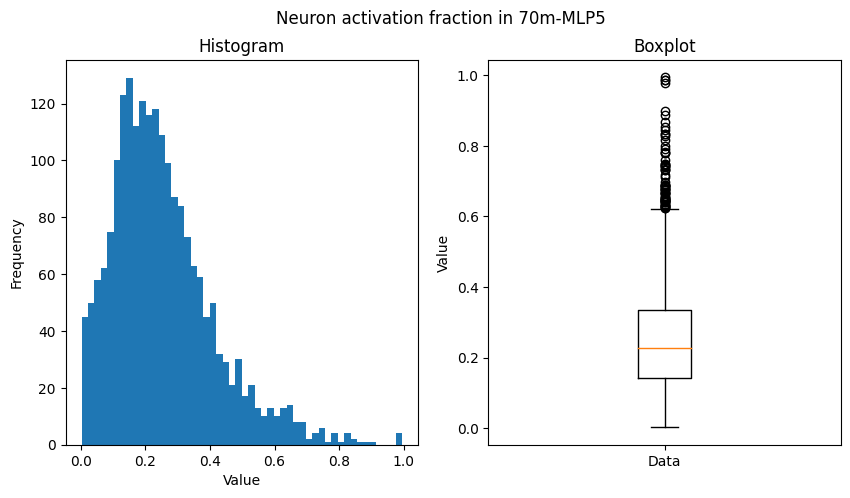

Using pad_token, but it is not set yet.


Loaded pretrained model pythia-160m-deduped into HookedTransformer


100%|██████████| 10/10 [00:00<00:00, 10.15it/s]


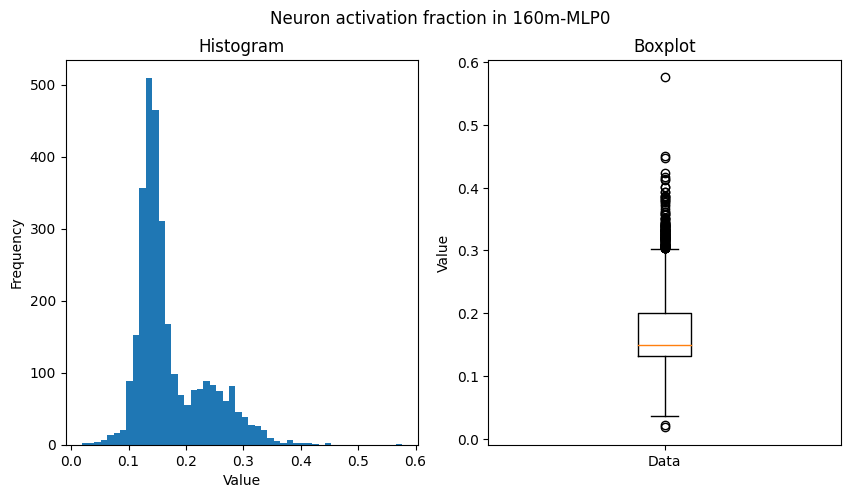

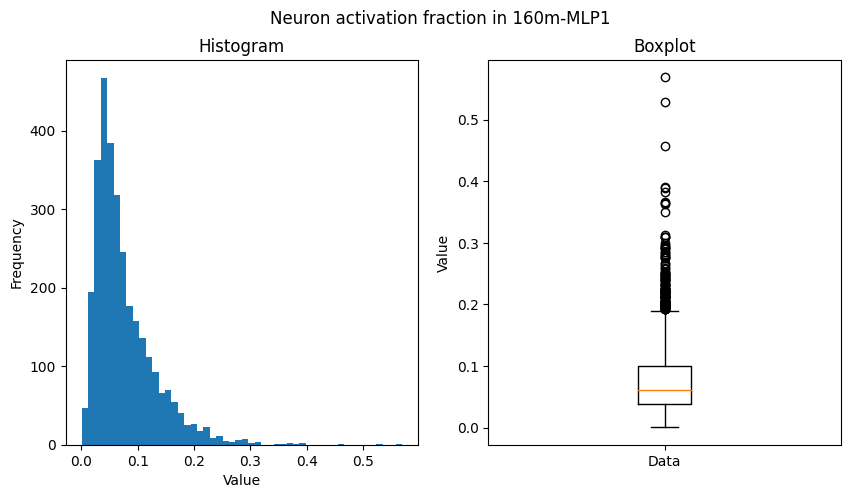

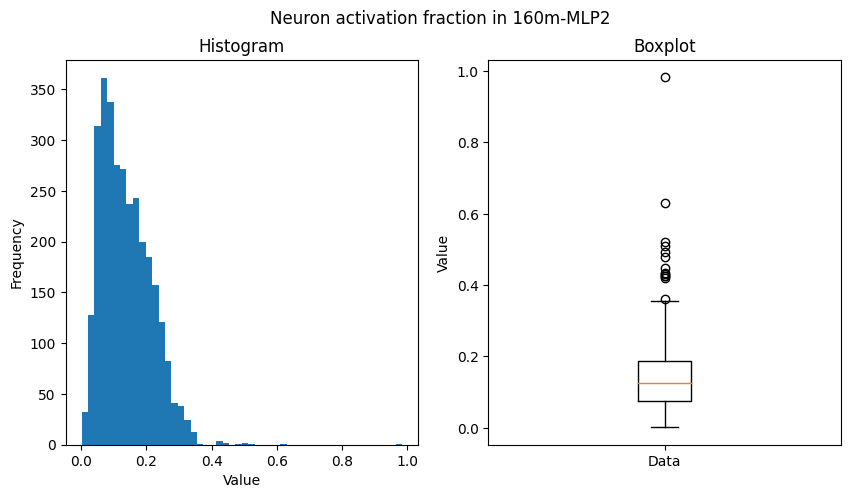

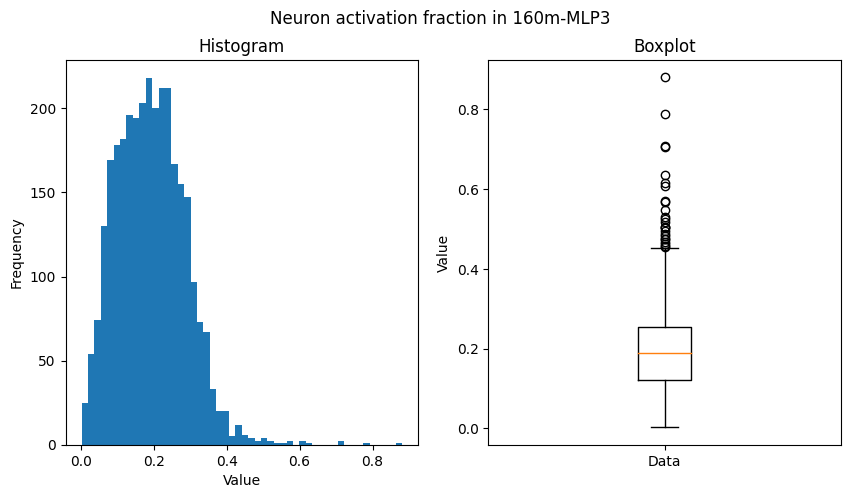

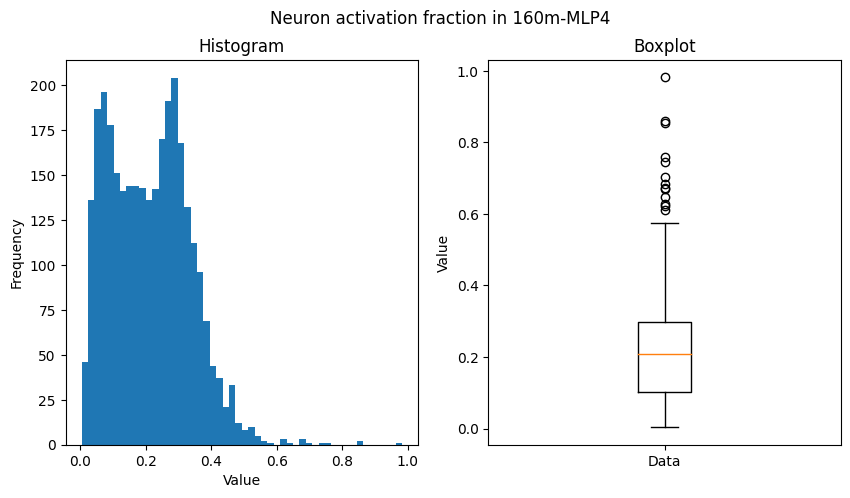

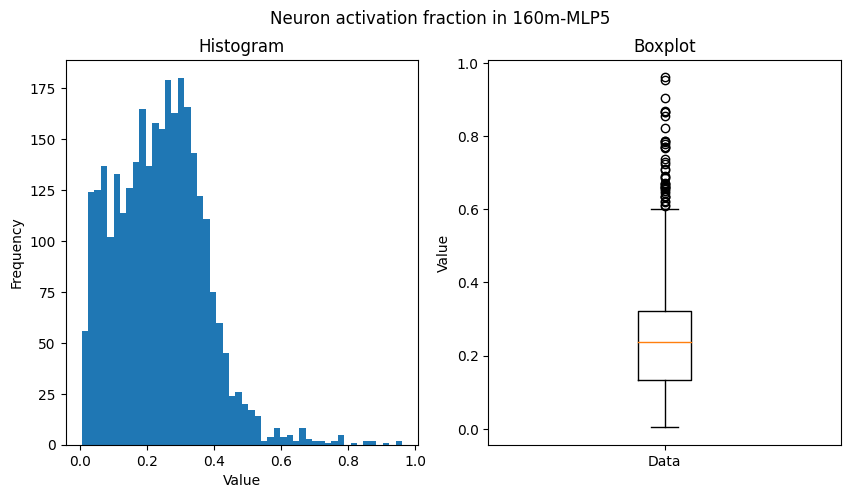

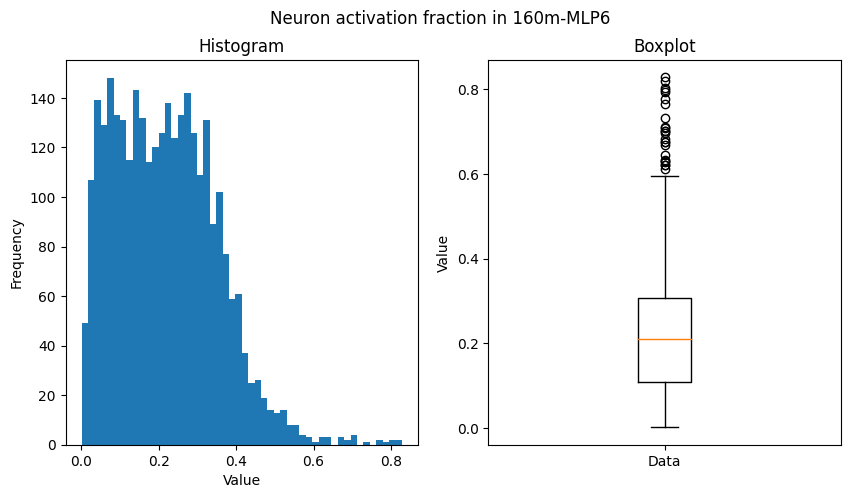

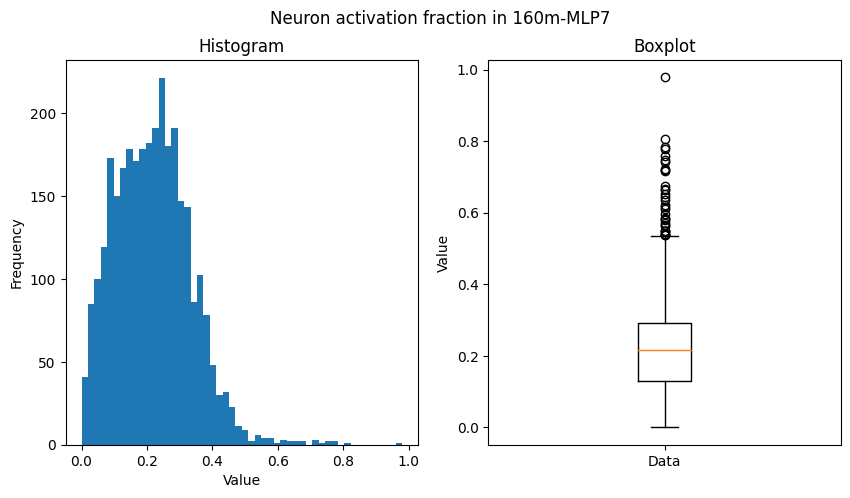

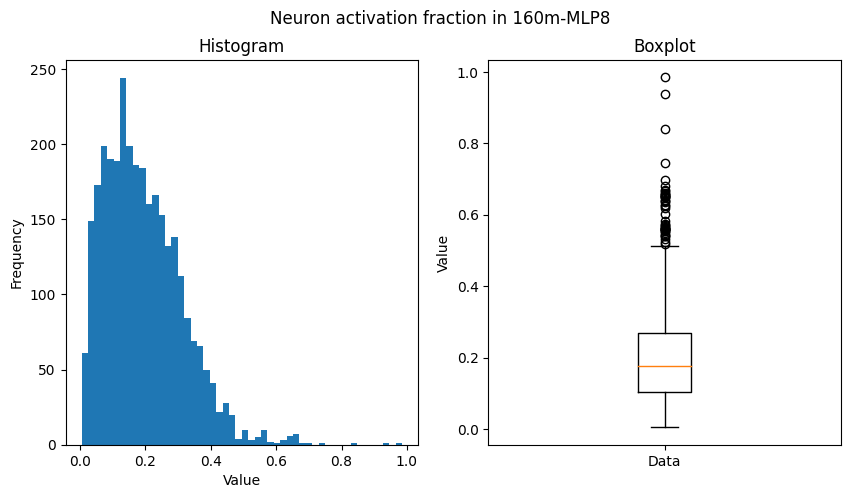

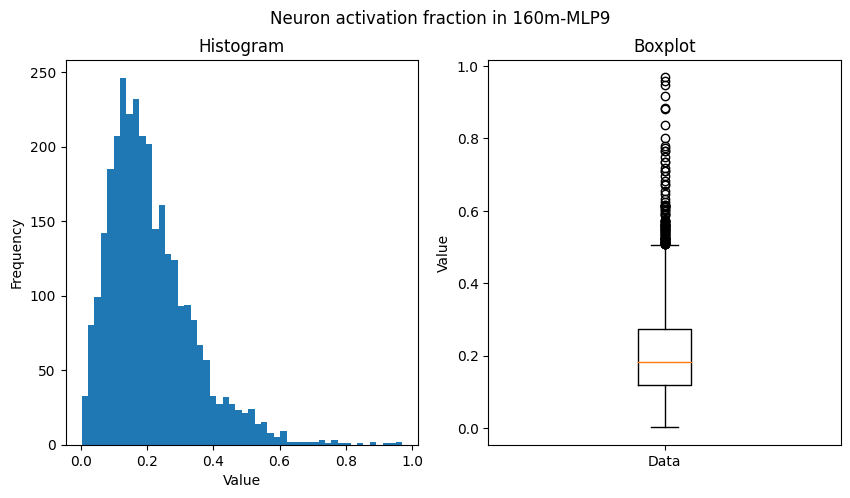

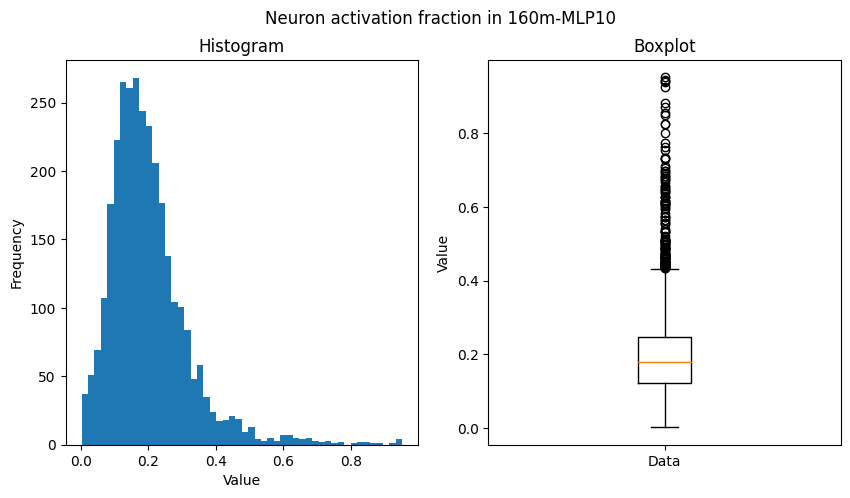

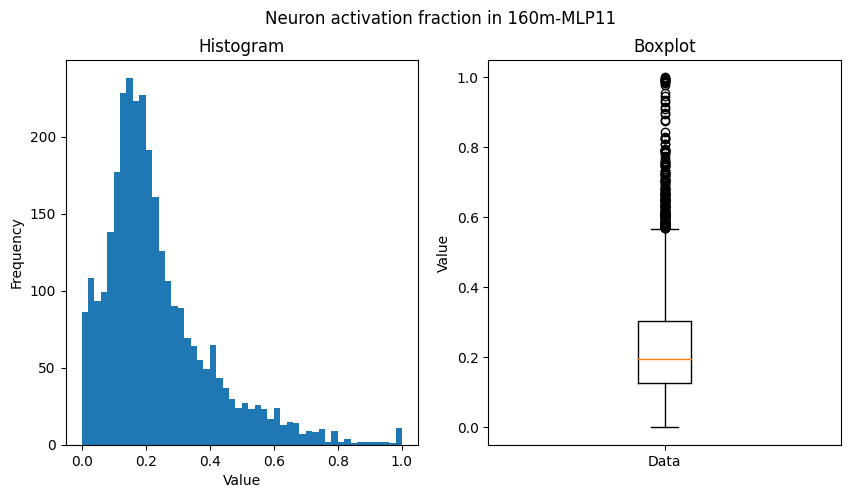

Using pad_token, but it is not set yet.


Loaded pretrained model pythia-410m-deduped into HookedTransformer


100%|██████████| 10/10 [00:02<00:00,  3.97it/s]


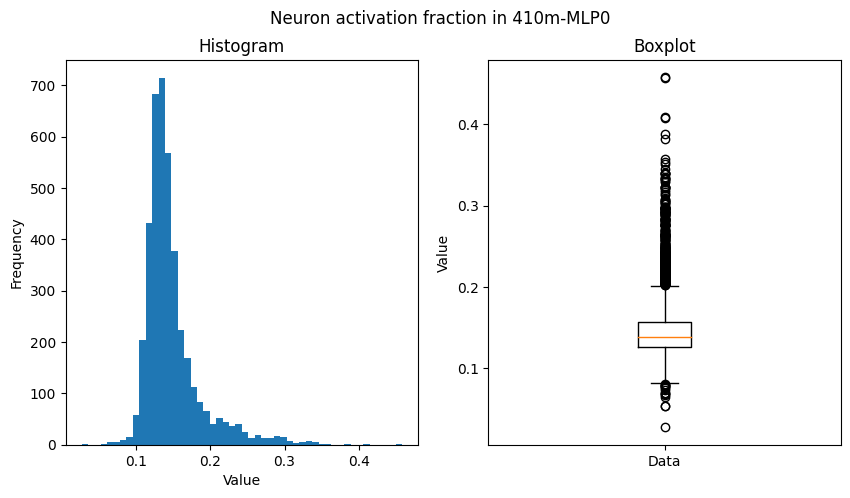

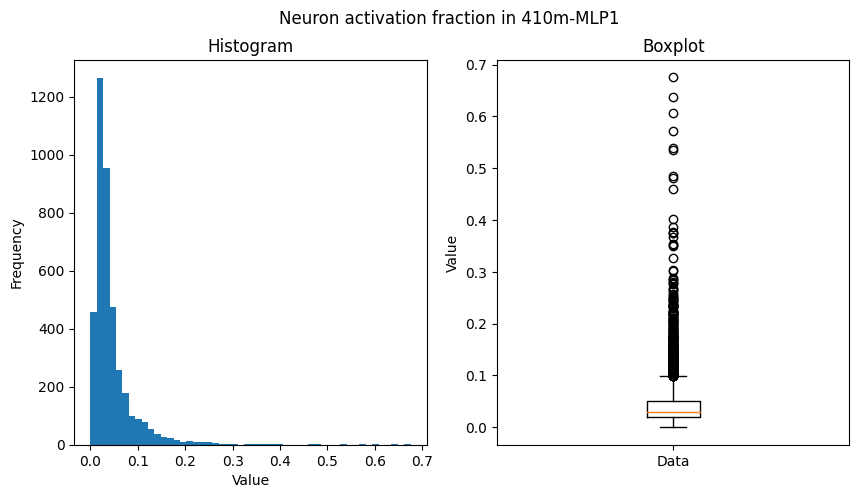

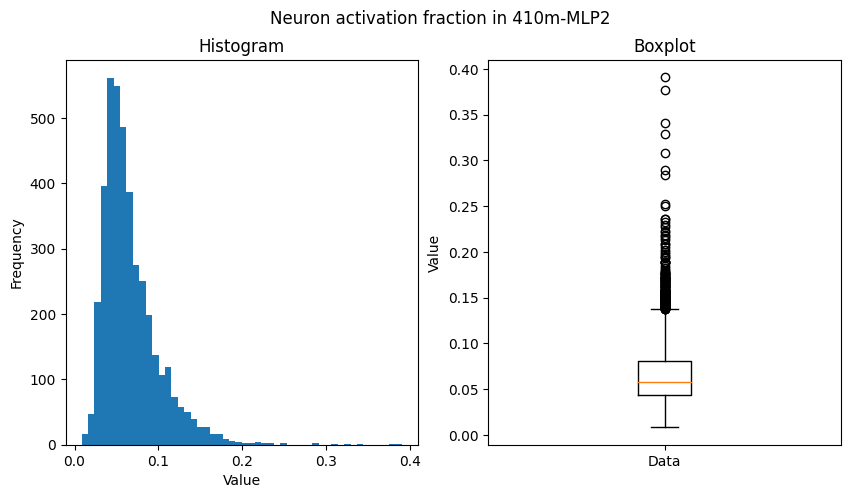

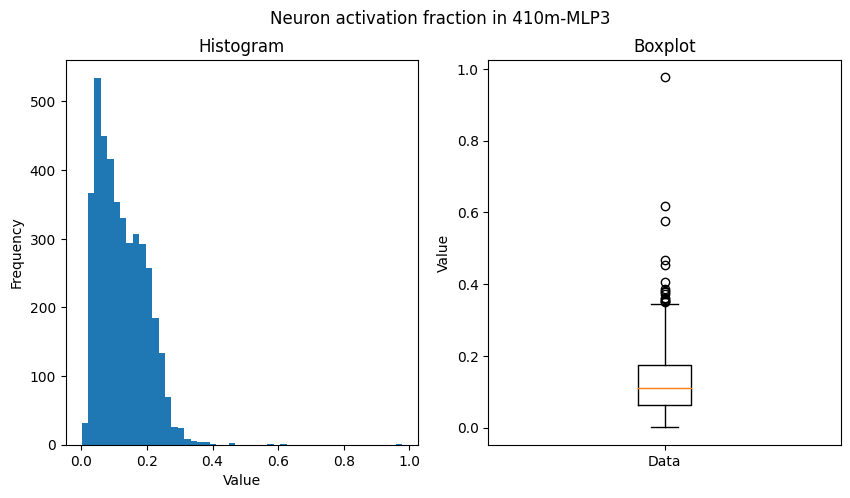

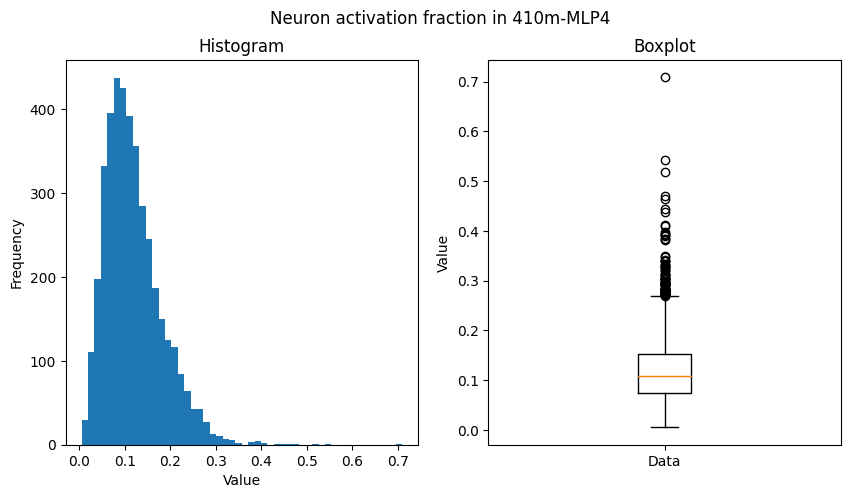

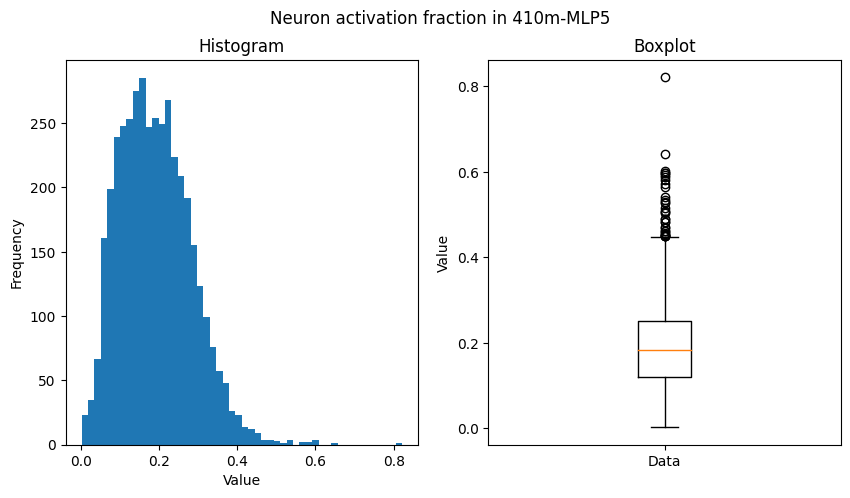

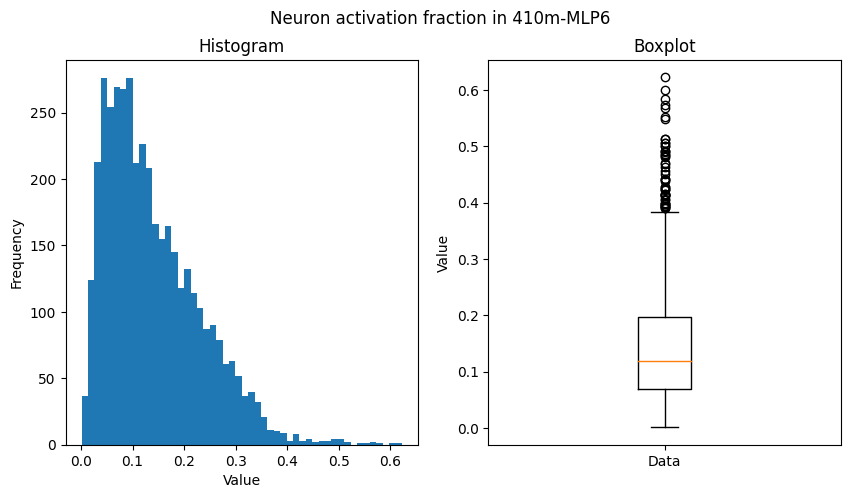

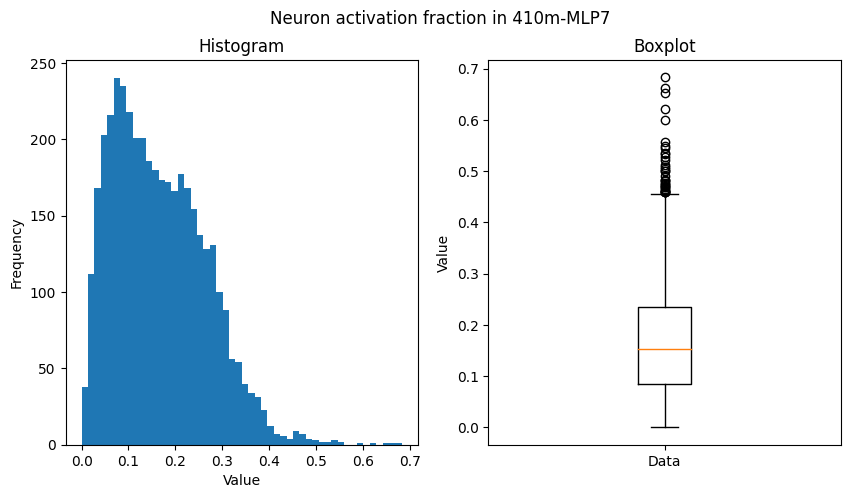

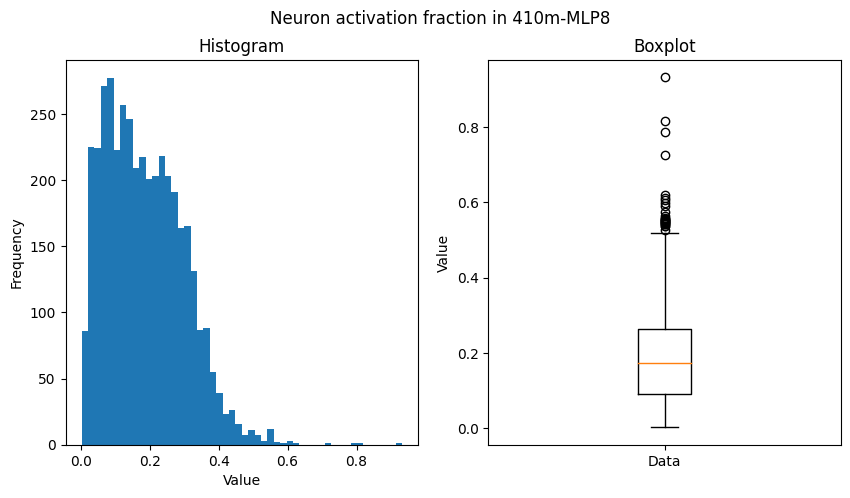

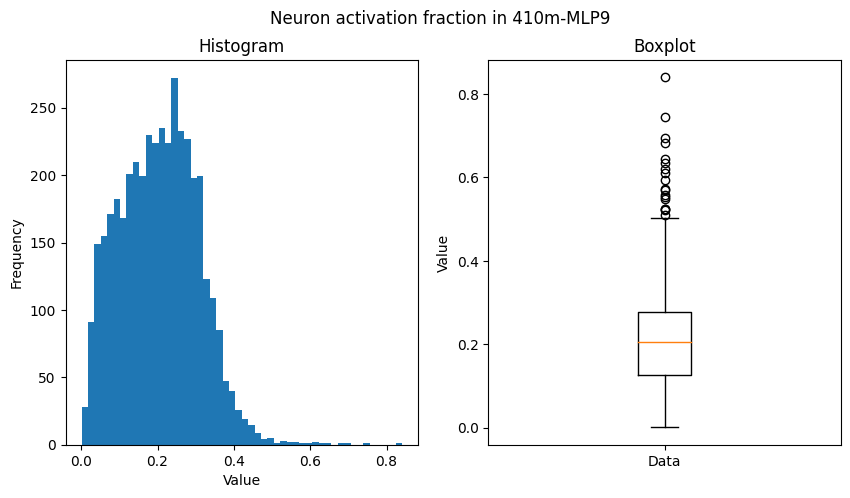

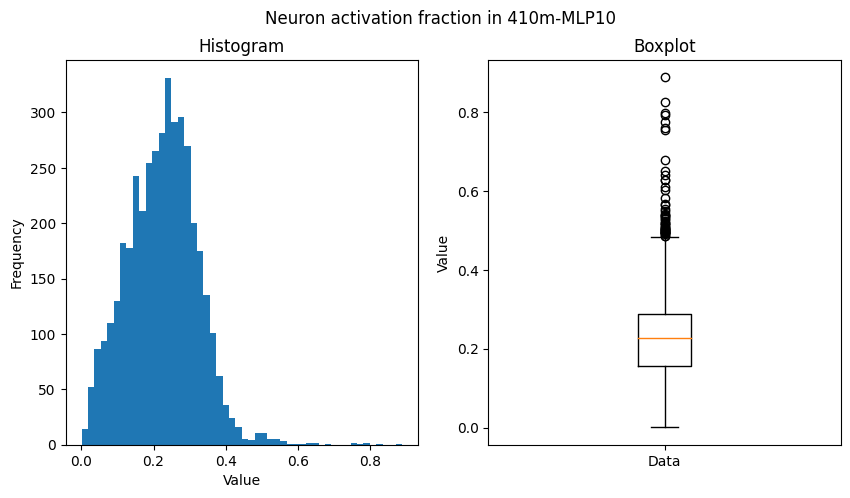

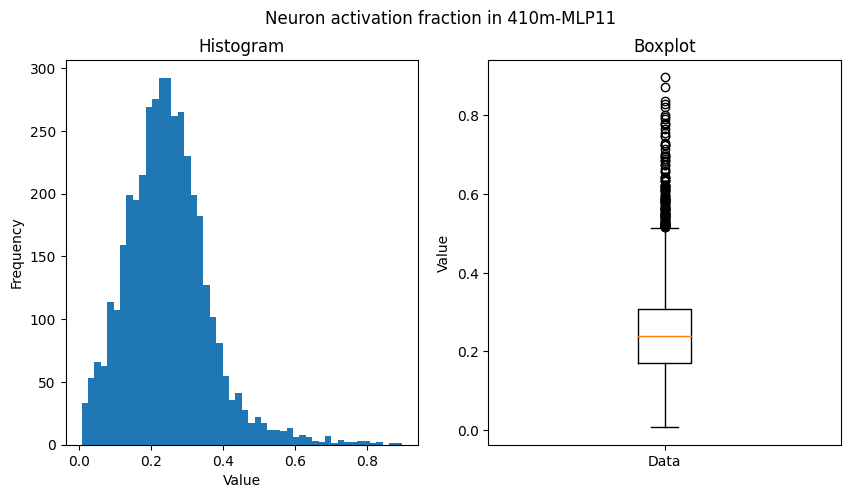

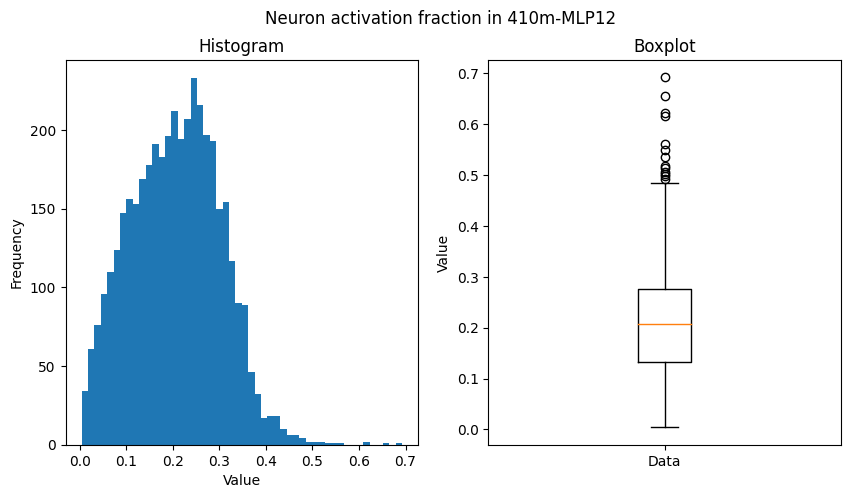

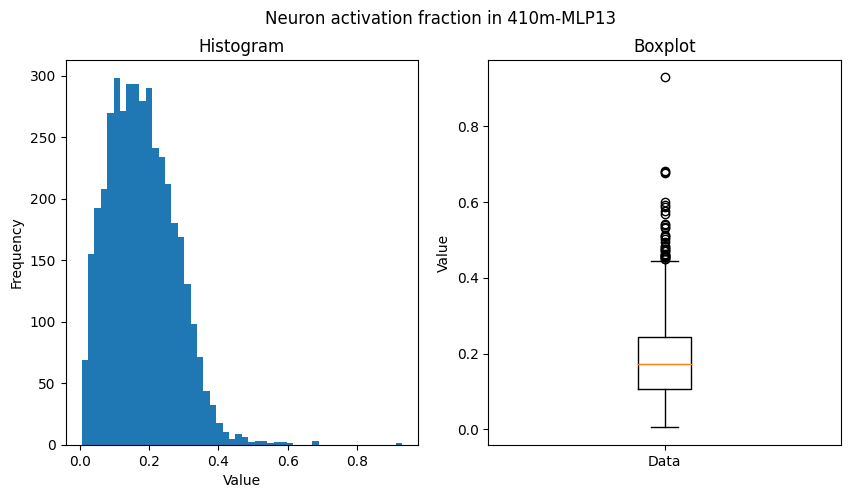

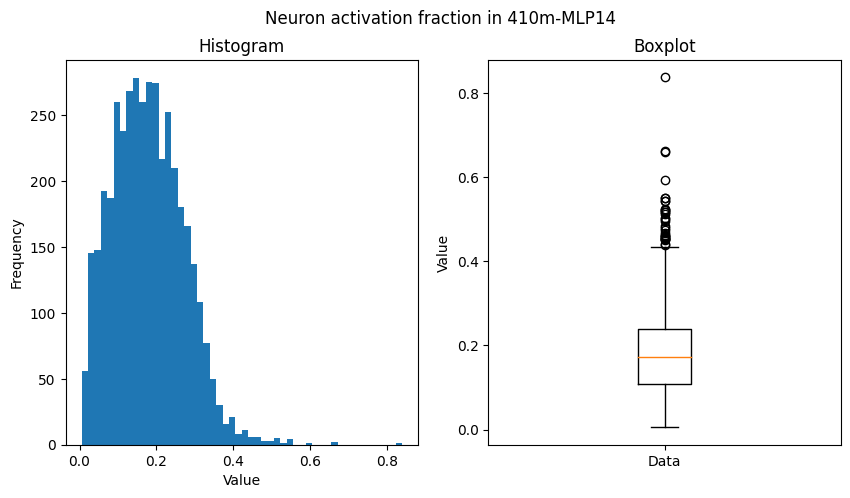

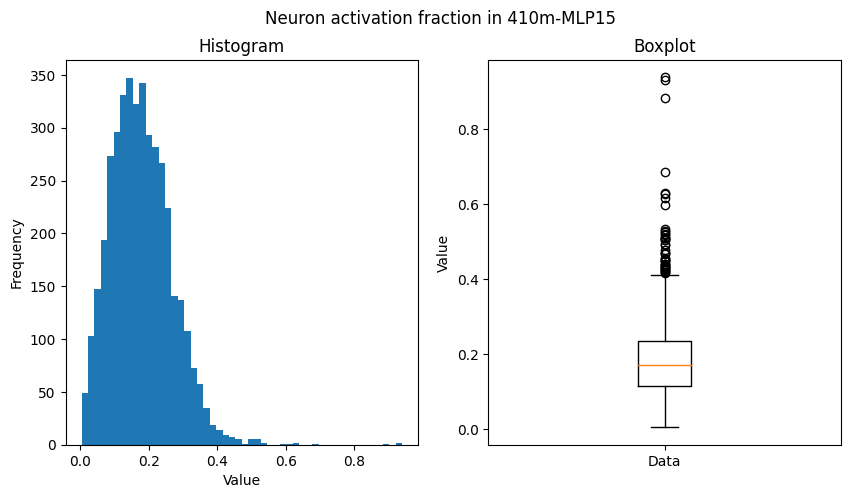

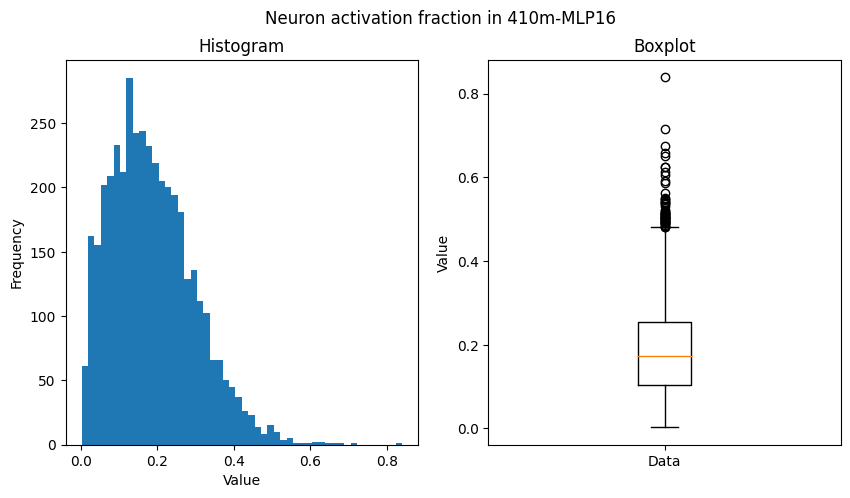

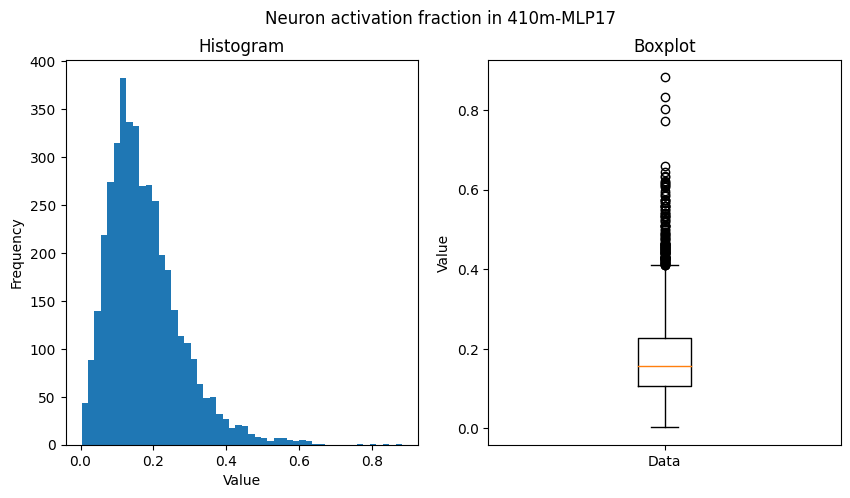

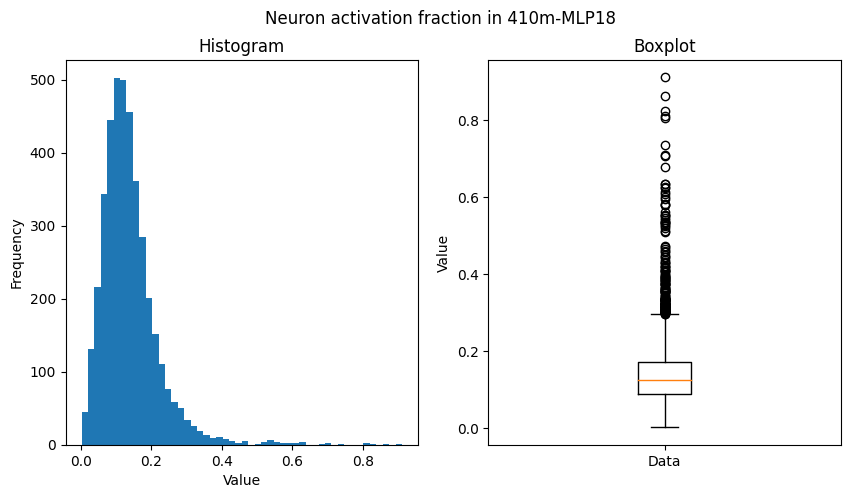

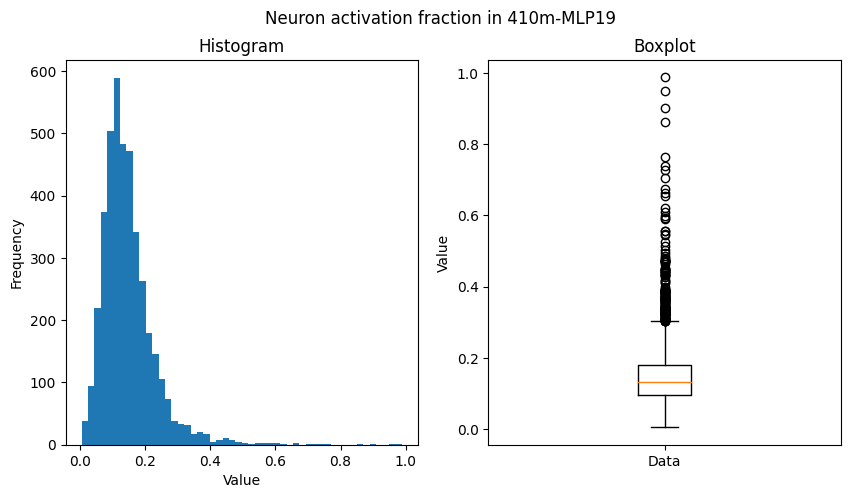

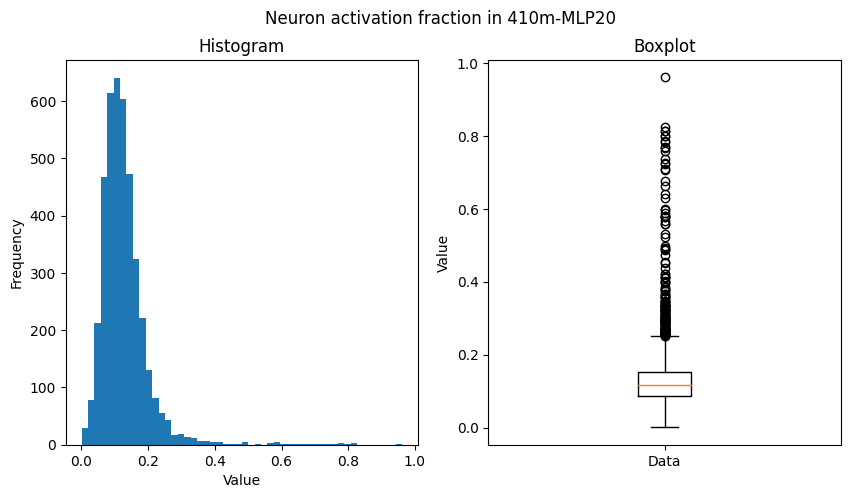

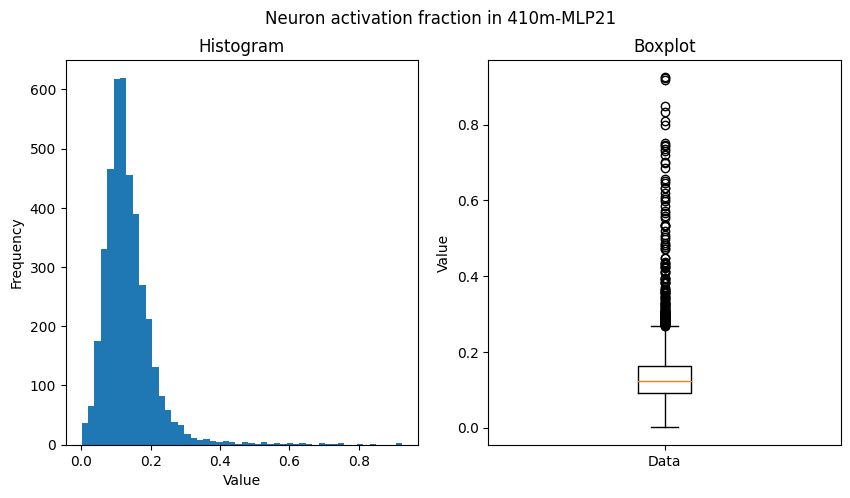

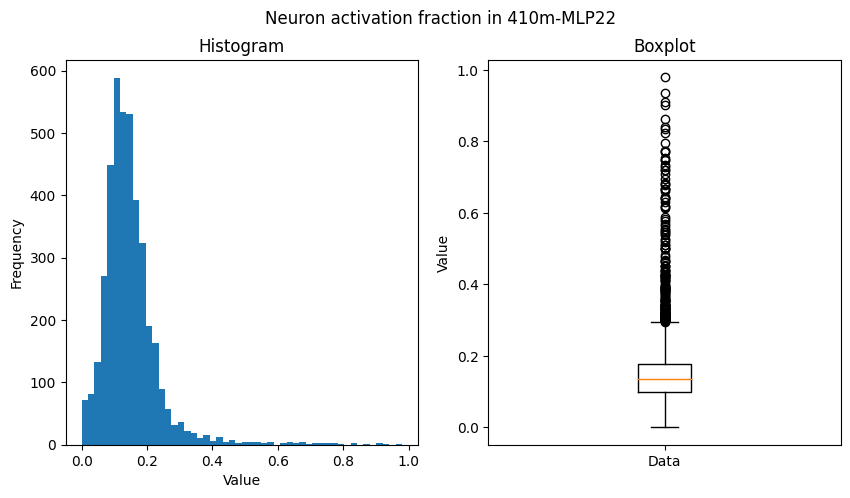

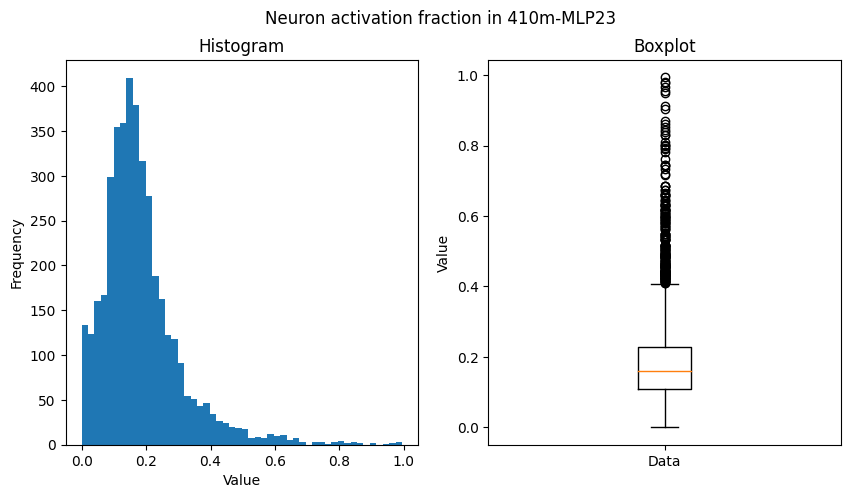

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 2>:3                                                                              │
│                                                                                                  │
│ /content/pythia_tools/pythia_tools/models.py:32 in yield_models                                  │
│                                                                                                  │
│   29                                                                                             │
│   30 def yield_models(lens=False):                                                               │
│   31 │   for model_name in model_names:                                                          │
│ ❱ 32 │   │   model = get_model(model_name, 143, lens)                                            │
│   33 │   │   yield (model_name, model)                                                           │
│   34                                                                                             │
│   35 def get_n_layers(model):                                                                    │
│                                                                                                  │
│ /content/pythia_tools/pythia_tools/models.py:25 in get_model                                     │
│                                                                                                  │
│   22 def get_model(size, rev, lens=False):                                                       │
│   23 │   if lens:                                                                                │
│   24 │   │   # transformerlens has rev 0 indexed, so we subtract 1                               │
│ ❱ 25 │   │   model = HookedTransformer.from_pretrained(f"pythia-{size}-deduped", checkpoint_i    │
│   26 │   else:                                                                                   │
│   27 │   │   model = GPTNeoXForCausalLM.from_pretrained(f"EleutherAI/pythia-{size}-deduped",     │
│   28 │   return model                                                                            │
│                                                                                                  │
│ /usr/local/lib/python3.9/dist-packages/transformer_lens/HookedTransformer.py:696 in              │
│ from_pretrained                                                                                  │
│                                                                                                  │
│    693 │   │   )                                                                                 │
│    694 │   │                                                                                     │
│    695 │   │   # Get the state dict of the model (ie a mapping of parameter names to tensors),   │
│ ❱  696 │   │   state_dict = loading.get_pretrained_state_dict(                                   │
│    697 │   │   │   official_model_name, cfg, hf_model                                            │
│    698 │   │   )                                                                                 │
│    699                                                                                           │
│                                                                                                  │
│ /usr/local/lib/python3.9/dist-packages/transformer_lens/loading_from_pretrained.py:717 in        │
│ get_pretrained_state_dict                                                                        │
│                                                                                                  │
│    714 │   │   │   │   │   official_model_name, revision=f"checkpoint-{cfg.checkpoint_value}"    │
│    715 │   │   │   │   )                                                                         │
│    716 │   │   │   elif official_model_name.startswith("Ele

In [12]:
data = {}
with open("plots_act_frac.md", "w") as f:
  for model_size, model in yield_models(lens=True):
    pres_all = get_many_pres_all_layers(model, torch.arange(0,10))
    neurons_act_frac_list = []
    for layer_id in range(get_n_layers(model)):
      neurons_act_frac = (pres_all[:,layer_id,:,:].reshape(pres_all.shape[0] * pres_all.shape[2], pres_all.shape[3]) > 0).float().mean(dim=0).detach().cpu()
      png_path = f'plots/mlp_act_frac_{model_size}-{layer_id}.png'
      hist_and_box(neurons_act_frac, 
                  title=f'Neuron activation fraction in {model_size}-MLP{layer_id}',
                  save_filename=png_path)
      f.write(f"![Layer {layer_id} Plots]({png_path})\n\n")
      neurons_act_frac_list.append(neurons_act_frac)
    data[model_size] = torch.stack(neurons_act_frac_list)
    del pres_all
    del model
    torch.cuda.empty_cache()

In [13]:
data

{'70m': tensor([[0.1295, 0.0803, 0.1483,  ..., 0.1387, 0.1365, 0.1628],
         [0.0495, 0.1297, 0.1138,  ..., 0.0780, 0.1748, 0.1705],
         [0.2195, 0.1812, 0.2908,  ..., 0.2172, 0.1527, 0.1132],
         [0.1162, 0.1303, 0.3768,  ..., 0.2865, 0.3723, 0.3270],
         [0.1705, 0.4557, 0.2758,  ..., 0.0510, 0.5628, 0.2258],
         [0.2022, 0.0713, 0.0360,  ..., 0.2070, 0.3383, 0.3102]]),
 '160m': tensor([[0.1503, 0.1805, 0.1228,  ..., 0.1532, 0.1597, 0.1540],
         [0.1107, 0.1072, 0.0198,  ..., 0.0505, 0.0268, 0.0583],
         [0.0798, 0.0555, 0.2253,  ..., 0.0227, 0.1530, 0.2223],
         ...,
         [0.1098, 0.1050, 0.0025,  ..., 0.1598, 0.0307, 0.2952],
         [0.1878, 0.1855, 0.0827,  ..., 0.1090, 0.1845, 0.2813],
         [0.5337, 0.2070, 0.2095,  ..., 0.2122, 0.6603, 0.0035]]),
 '410m': tensor([[0.1405, 0.1917, 0.1240,  ..., 0.1315, 0.1287, 0.1272],
         [0.0393, 0.1133, 0.0265,  ..., 0.0420, 0.0640, 0.0185],
         [0.0360, 0.0385, 0.0453,  ..., 0.0725, 0

In [15]:
import os
import zipfile

def create_zip_archive(input_dir, output_path):
    with zipfile.ZipFile(output_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, _, files in os.walk(input_dir):
            for file in files:
                file_path = os.path.join(root, file)
                zipf.write(file_path, os.path.relpath(file_path, input_dir))


In [16]:
create_zip_archive('/content/plots', '/content/mlp_act_frac_plots.zip')

In [31]:
layer_id = 11
neurons_act_frac = (pres_all[:,layer_id,:,:].reshape(pres_all.shape[0] * pres_all.shape[2], pres_all.shape[3]) > 0).float().mean(dim=0)

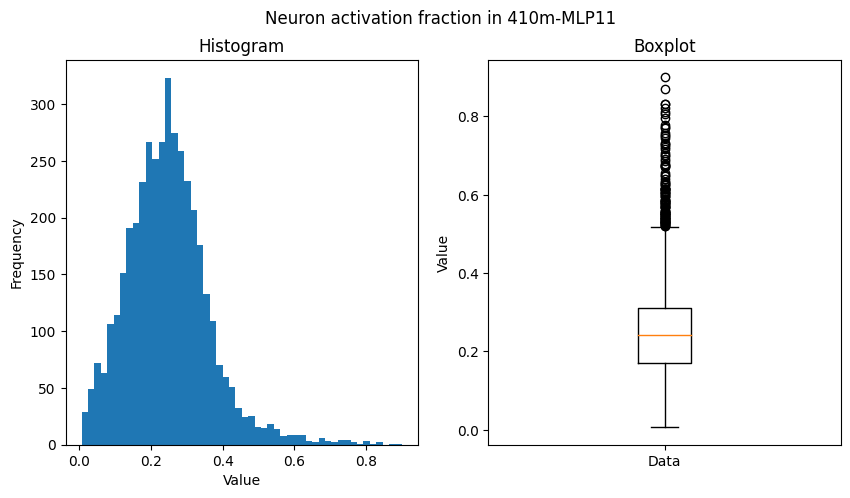

In [32]:
hist_and_box(neurons_act_frac.detach().cpu(), title=f'Neuron activation fraction in {model_size}-MLP{layer_id}')

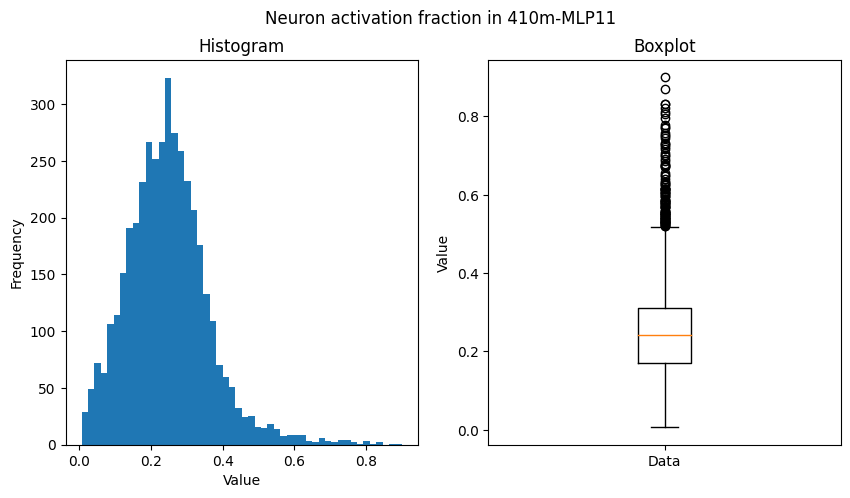

In [31]:
hist_and_box(neurons_act_frac.detach().cpu(), title=f'Neuron activation fraction in {model_size}-MLP{layer_id}')

In [14]:
for layer_id in range(get_n_layers(model)):
  neurons_act_frac
  hist_and_box(neurons_act_frac, title=f'How often does a neuron activate? {model_size}-L{layer_id}'

torch.Size([4096])

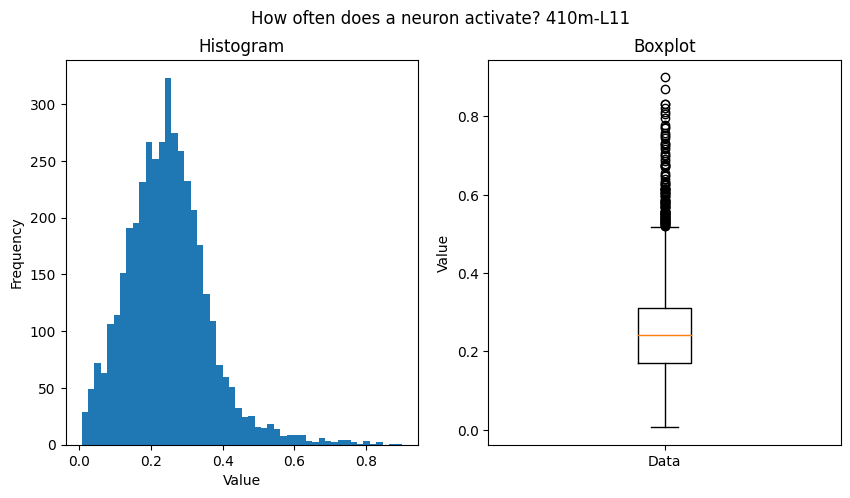

In [15]:
)

In [ ]:
per_neuron_frac_pos_active = pres_bin.mean(dim=1)

In [ ]:
per_neuron_frac_pos_active.shape

torch.Size([20, 4096])

In [ ]:
per_pos_frac_neurons_active = pres_bin.mean(dim=2)
per_pos_frac_neurons_active.shape

torch.Size([10, 600])

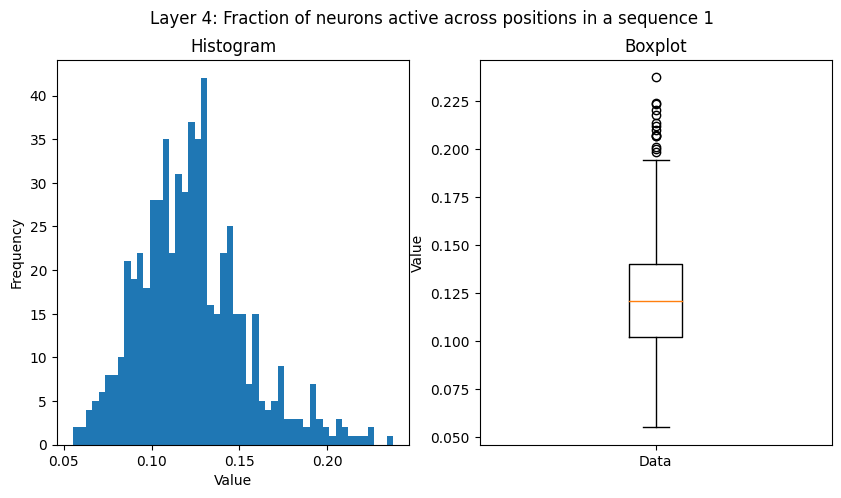

In [ ]:
hist_and_box(per_pos_frac_neurons_active[5], title=f'Layer {layer}: Fraction of neurons active across positions in a sequence 1')

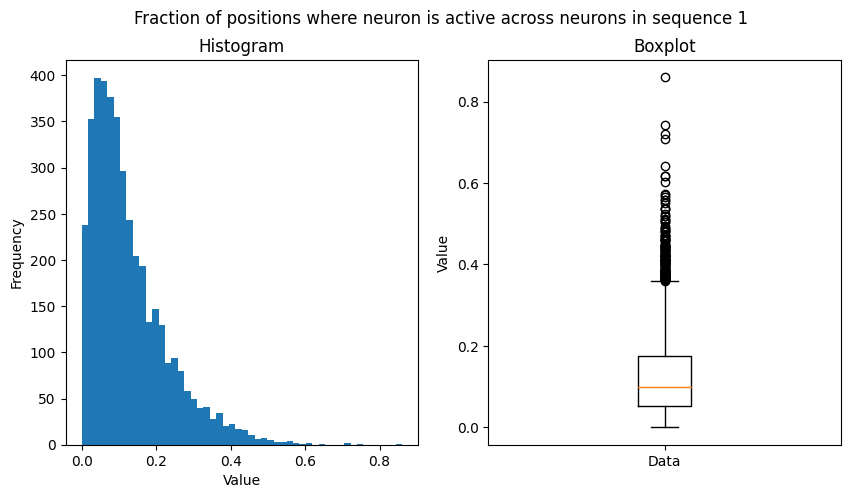

In [ ]:
hist_and_box(per_neuron_frac_pos_active[1], title='Fraction of positions where neuron is active across neurons in sequence 1')

In [ ]:
pres.shape

torch.Size([10, 600, 4096])

In [ ]:
bins_per_neuron = pres_bin.reshape(-1, 4096).T
bins_per_neuron.shape

torch.Size([4096, 6000])

In [ ]:
pres_bin[:,:,3364].mean(dim=1)

tensor([0.7950, 0.7083, 0.6350, 0.6583, 0.6883, 0.7067, 0.8000, 0.6883, 0.7000,
        0.7083])

In [ ]:
3364

In [ ]:
neurons_act_frac.argsort(descending=True)

tensor([3364,  890, 1163,  ...,  735, 4084, 3314])

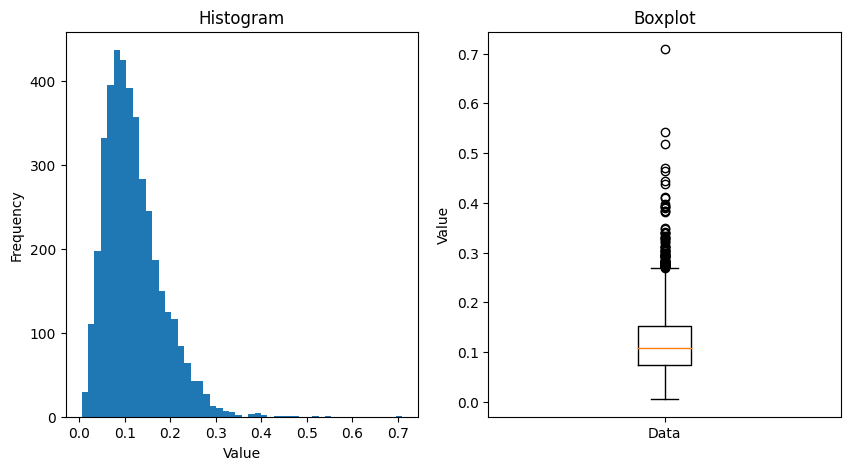

In [ ]:
neurons_act_frac = bins_per_neuron.mean(dim=1)
_ = hist_and_box(neurons_act_frac)

In [ ]:
pres_per_neuron = pres.reshape(-1, 4096).T
pres_per_neuron.shape

torch.Size([4096, 6000])

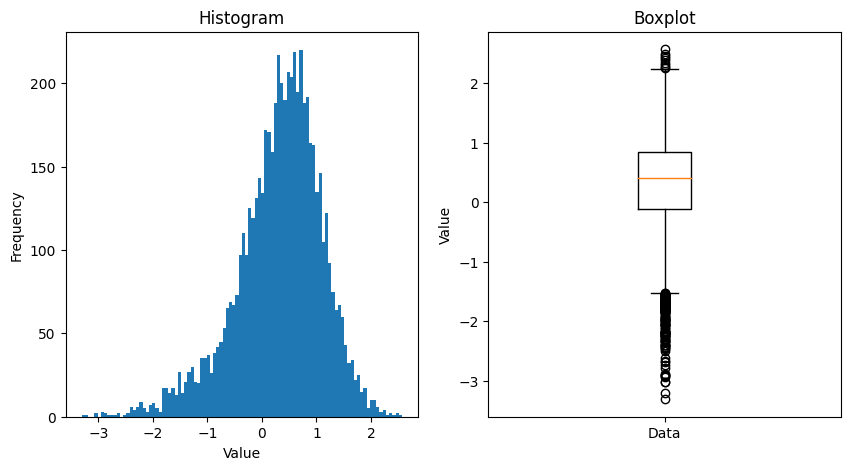

In [ ]:
_ = hist_and_box(pres_per_neuron[3364],bins=100)

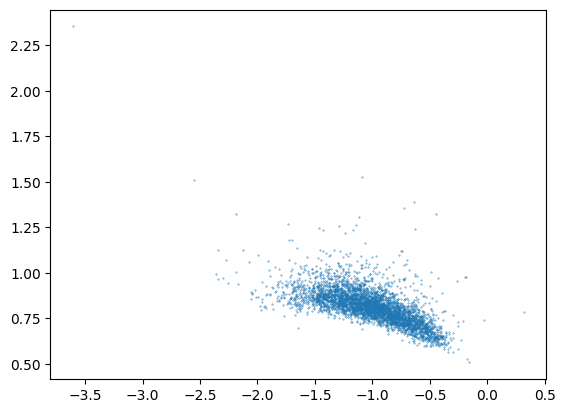

In [ ]:
plt.scatter(pres_per_neuron.mean(dim=1), pres_per_neuron.std(dim=1),s=0.1)

In [ ]:
model2 = get_model('410m', 143, False)

getmodel6
good


In [ ]:
from pythia_tools.deembedding import get_mlp_out

In [ ]:
W_out = get_mlp_out(model2, 4).detach()

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 1>:1                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'get_mlp_out' is not defined

In [ ]:
W_out.shape

torch.Size([1024, 4096])

In [ ]:
torch.norm(W_out,dim=0).argsort(descending=True)

tensor([4056, 3418, 1632,  ..., 3581, 3364, 1235])

In [ ]:
torch.argwhere(torch.norm(W_out,dim=0).argsort(descending=True) == 3364)

tensor([[4094]])

In [ ]:
torch.norm(W_out,dim=0)[]

tensor([0.5816, 0.5674, 0.6075,  ..., 0.6120, 0.5970, 0.7466])

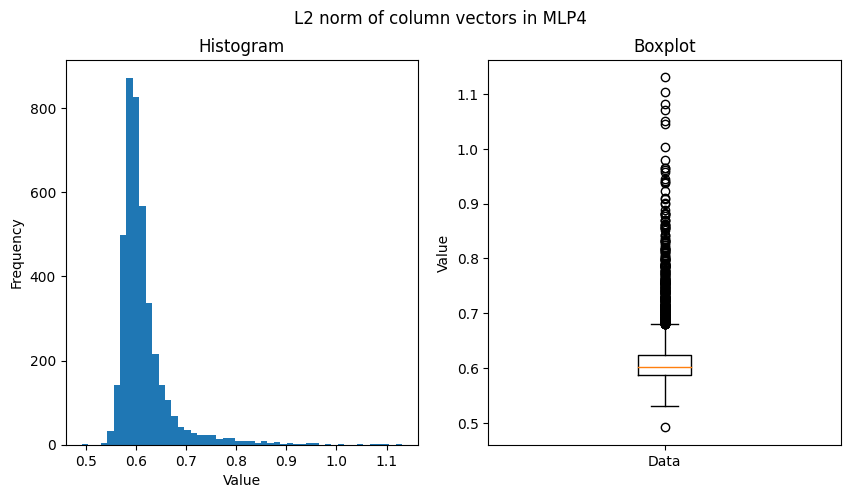

In [ ]:
hist_and_box(torch.norm(W_out,dim=0), title='L2 norm of column vectors in MLP4')

In [ ]:
W_in = model2.gpt_neox.layers[4].mlp.dense_h_to_4h.weight.detach()

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 1>:1                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'model2' is not defined

In [ ]:
(torch.norm(W_in,dim=1) < torch.norm(W_in,dim=1)[3364]).float().mean()

tensor(0.0413)

In [ ]:
torch.argwhere(torch.norm(W_in,dim=1).argsort(descending=True) == 3364)

tensor([[3926]])

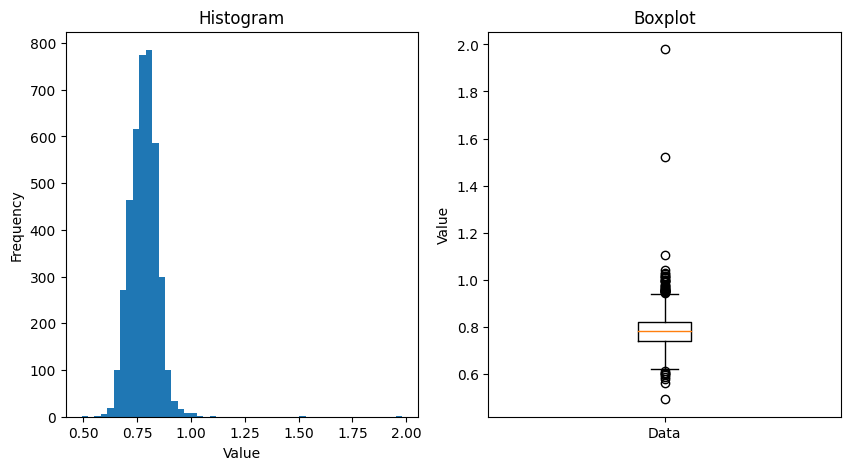

In [ ]:
hist_and_box(torch.norm(W_in,dim=1))

In [ ]:
W_in

tensor([[-0.0222, -0.0235,  0.0020,  ...,  0.0026, -0.0113, -0.0084],
        [-0.0111, -0.0569, -0.0098,  ..., -0.0312,  0.0197, -0.0200],
        [ 0.0229,  0.0016, -0.0070,  ...,  0.0011, -0.0086,  0.0211],
        ...,
        [ 0.0109,  0.0388,  0.0093,  ..., -0.0211, -0.0378,  0.0057],
        [-0.0230, -0.0156, -0.0175,  ...,  0.0022,  0.0369,  0.0253],
        [-0.0050,  0.0067, -0.0085,  ..., -0.0132,  0.0288,  0.0077]])

In [ ]:
W_in_sim = get_similarity_matrix(W_in)
W_in_sim.shape

torch.Size([4096, 4096])

In [ ]:
(W_in_sim - torch.eye(4096)).max()

tensor(0.7176)

In [ ]:
(W_in_sim - torch.eye(4096)).min()

tensor(-0.7086)

In [ ]:
pres_bin.reshape(-1, 4096).mean(dim=0).mean()

In [ ]:
import torch

def off_diagonal_elements(matrix: torch.Tensor) -> torch.Tensor:
    if matrix.dim() != 2 or matrix.size(0) != matrix.size(1):
        raise ValueError("Input must be a square matrix.")

    if not torch.allclose(matrix, matrix.transpose(0, 1), atol=1e-6):
        raise ValueError("Input must be a symmetric matrix.")

    # Create a boolean mask for the off-diagonal elements
    mask = ~torch.eye(matrix.size(0), dtype=torch.bool, device=matrix.device)

    # Extract the off-diagonal elements using the mask
    off_diagonal_elements = matrix[mask]

    return off_diagonal_elements

def sample_elements(tensor: torch.Tensor, n: int, with_replacement: bool = False) -> torch.Tensor:
    if n < 0:
        raise ValueError("n must be non-negative.")
    
    # Reshape the tensor to 1D if necessary
    if tensor.dim() != 1:
        tensor = tensor.flatten()

    num_elements = tensor.size(0)

    if n > num_elements and not with_replacement:
        raise ValueError("n must be less than or equal to the number of elements when sampling without replacement.")

    if with_replacement:
        # Sampling with replacement
        indices = torch.randint(0, num_elements, (n,))
    else:
        # Sampling without replacement
        indices = torch.randperm(num_elements)[:n]

    sampled_elements = tensor[indices]
    return sampled_elements

In [ ]:
W_in_sim_off = off_diagonal_elements(W_in_sim)

In [ ]:
W_in_sim_off.mean()

tensor(0.0170)

In [ ]:
W_in_sim_off.median()

tensor(0.0170)

In [ ]:
hej = sample_elements(W_in_sim_off, 0.1)
hej.shape

torch.Size([1677312])

Subsampling to 100K


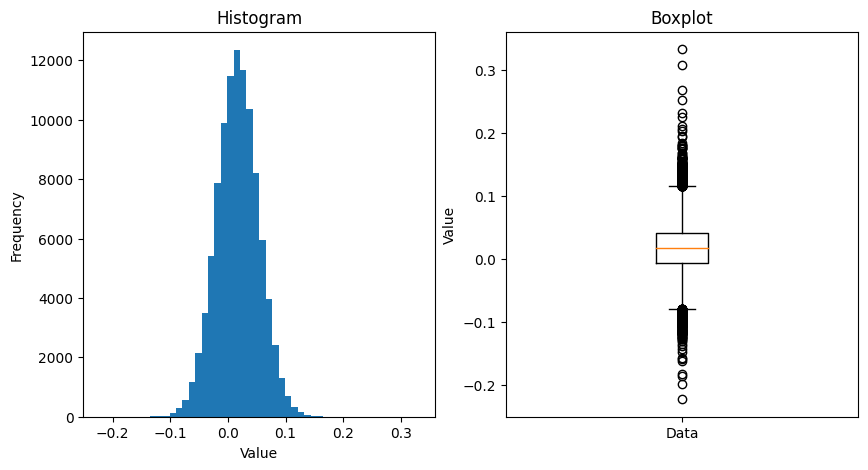

In [ ]:
hist_and_box(W_in_sim_off)